In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False, 
                 imaging_type_encoder=None, fit_imaging_type_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_imaging_type_encoder (bool): Whether to fit the imaging type encoder.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type labels
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_imaging_type_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_imaging_type_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding and imaging type encoding
    """
    # Create training dataset and fit both label encoders
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True,
        fit_imaging_type_encoder=True
    )
    
    # Get the fitted label encoders
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same encoders
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same encoders
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        ax2.set_xlabel('Epoch')

# Model Definitions

In [12]:
class CoAtNetWithImagingType(nn.Module):
    """CoAtNet with imaging type as additional input"""
    
    def __init__(self, model_type='0', num_classes=4, num_imaging_types=2, pretrained=True, embedding_dim=16):
        super(CoAtNetWithImagingType, self).__init__()
        
        # Load pretrained CoAtNet using timm
        self.coatnet = timm.create_model(f'coatnet_{model_type}_rw_224.sw_in1k', pretrained=pretrained, num_classes=0)
        
        # Get the number of features from the model
        num_features = self.coatnet.num_features
        
        # Embedding layer for imaging type
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that combines CNN features and imaging type embedding
        self.classifier = nn.Sequential(
            nn.Linear(num_features + embedding_dim, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, images, imaging_types):
        # Extract features from CoAtNet
        features = self.coatnet(images)
        
        # Get imaging type embeddings
        imaging_embedding = self.imaging_type_embedding(imaging_types)
        
        # Concatenate features with imaging type embeddings
        combined_features = torch.cat([features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        
        return output


def create_coatnet_model(model_type='0', num_classes=4, num_imaging_types=2, pretrained=True, embedding_dim=16):
    """
    Create CoAtNet (Convolution and Attention Network) model with imaging type
    
    Args:
        model_type (str): Model variant - '0', '1', '2', '3', '4'
        num_classes (int): Number of output classes
        num_imaging_types (int): Number of imaging types (e.g., WLI, NBI)
        pretrained (bool): Whether to use pretrained weights
        embedding_dim (int): Dimension of imaging type embedding
    
    Returns:
        model: CoAtNet model with imaging type support
    """
    model = CoAtNetWithImagingType(
        model_type=model_type,
        num_classes=num_classes,
        num_imaging_types=num_imaging_types,
        pretrained=pretrained,
        embedding_dim=embedding_dim
    )
    return model


# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train CoAtNet-0

Training CoAtNet-0 with Imaging Type
Number of imaging types: 2
Imaging types: ['NBI' 'WLI']


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.64it/s, Loss=1.4379, Acc=0.2492]


Train Loss: 1.4379 Acc: 0.2492 Macro-F1: 0.2363


Val : 100%|██████████| 10/10 [00:01<00:00,  5.52it/s, Loss=1.3758, Acc=0.3684]


Val Loss: 1.3758 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=1.3889, Acc=0.2525]


Train Loss: 1.3889 Acc: 0.2525 Macro-F1: 0.2421


Val : 100%|██████████| 10/10 [00:01<00:00,  7.43it/s, Loss=1.3028, Acc=0.3914]


Val Loss: 1.3028 Acc: 0.3914 Macro-F1: 0.2426
✓ New best model saved with validation macro-F1: 0.2426

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=1.3326, Acc=0.3569]


Train Loss: 1.3326 Acc: 0.3569 Macro-F1: 0.3066


Val : 100%|██████████| 10/10 [00:01<00:00,  7.21it/s, Loss=1.3886, Acc=0.2961]


Val Loss: 1.3886 Acc: 0.2961 Macro-F1: 0.1852

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=1.1910, Acc=0.4449]


Train Loss: 1.1910 Acc: 0.4449 Macro-F1: 0.3895


Val : 100%|██████████| 10/10 [00:01<00:00,  7.19it/s, Loss=1.0616, Acc=0.5428]


Val Loss: 1.0616 Acc: 0.5428 Macro-F1: 0.4333
✓ New best model saved with validation macro-F1: 0.4333

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=1.0373, Acc=0.4992]


Train Loss: 1.0373 Acc: 0.4992 Macro-F1: 0.4517


Val : 100%|██████████| 10/10 [00:01<00:00,  7.30it/s, Loss=0.9999, Acc=0.4342]


Val Loss: 0.9999 Acc: 0.4342 Macro-F1: 0.3626

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.9725, Acc=0.5238]


Train Loss: 0.9725 Acc: 0.5238 Macro-F1: 0.4663


Val : 100%|██████████| 10/10 [00:01<00:00,  7.31it/s, Loss=3.3175, Acc=0.2500]


Val Loss: 3.3175 Acc: 0.2500 Macro-F1: 0.1590

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.9636, Acc=0.5082]


Train Loss: 0.9636 Acc: 0.5082 Macro-F1: 0.4749


Val : 100%|██████████| 10/10 [00:01<00:00,  7.22it/s, Loss=1.2257, Acc=0.4638]


Val Loss: 1.2257 Acc: 0.4638 Macro-F1: 0.3788

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.8545, Acc=0.5765]


Train Loss: 0.8545 Acc: 0.5765 Macro-F1: 0.5284


Val : 100%|██████████| 10/10 [00:01<00:00,  7.25it/s, Loss=1.0625, Acc=0.4803]


Val Loss: 1.0625 Acc: 0.4803 Macro-F1: 0.4084

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.98it/s, Loss=0.8266, Acc=0.6086]


Train Loss: 0.8266 Acc: 0.6086 Macro-F1: 0.5680


Val : 100%|██████████| 10/10 [00:01<00:00,  7.23it/s, Loss=0.8683, Acc=0.5855]


Val Loss: 0.8683 Acc: 0.5855 Macro-F1: 0.5017
✓ New best model saved with validation macro-F1: 0.5017

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.7819, Acc=0.6316]


Train Loss: 0.7819 Acc: 0.6316 Macro-F1: 0.5910


Val : 100%|██████████| 10/10 [00:01<00:00,  7.22it/s, Loss=0.7105, Acc=0.6480]


Val Loss: 0.7105 Acc: 0.6480 Macro-F1: 0.6019
✓ New best model saved with validation macro-F1: 0.6019

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.7731, Acc=0.6110]


Train Loss: 0.7731 Acc: 0.6110 Macro-F1: 0.5800


Val : 100%|██████████| 10/10 [00:01<00:00,  7.28it/s, Loss=0.6947, Acc=0.6480]


Val Loss: 0.6947 Acc: 0.6480 Macro-F1: 0.6189
✓ New best model saved with validation macro-F1: 0.6189

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.7207, Acc=0.6398]


Train Loss: 0.7207 Acc: 0.6398 Macro-F1: 0.6186


Val : 100%|██████████| 10/10 [00:01<00:00,  7.35it/s, Loss=1.8019, Acc=0.3618]


Val Loss: 1.8019 Acc: 0.3618 Macro-F1: 0.2271

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.7288, Acc=0.6472]


Train Loss: 0.7288 Acc: 0.6472 Macro-F1: 0.6201


Val : 100%|██████████| 10/10 [00:01<00:00,  7.31it/s, Loss=0.7864, Acc=0.6316]


Val Loss: 0.7864 Acc: 0.6316 Macro-F1: 0.6091

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.7012, Acc=0.6702]


Train Loss: 0.7012 Acc: 0.6702 Macro-F1: 0.6404


Val : 100%|██████████| 10/10 [00:01<00:00,  7.30it/s, Loss=1.0127, Acc=0.5000]


Val Loss: 1.0127 Acc: 0.5000 Macro-F1: 0.4592

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.6819, Acc=0.6431]


Train Loss: 0.6819 Acc: 0.6431 Macro-F1: 0.6194


Val : 100%|██████████| 10/10 [00:01<00:00,  7.18it/s, Loss=0.6258, Acc=0.7072]


Val Loss: 0.6258 Acc: 0.7072 Macro-F1: 0.6734
✓ New best model saved with validation macro-F1: 0.6734

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.96it/s, Loss=0.6586, Acc=0.6875]


Train Loss: 0.6586 Acc: 0.6875 Macro-F1: 0.6634


Val : 100%|██████████| 10/10 [00:01<00:00,  7.17it/s, Loss=0.6230, Acc=0.7039]


Val Loss: 0.6230 Acc: 0.7039 Macro-F1: 0.6700

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.6705, Acc=0.6785]


Train Loss: 0.6705 Acc: 0.6785 Macro-F1: 0.6473


Val : 100%|██████████| 10/10 [00:01<00:00,  7.22it/s, Loss=0.6202, Acc=0.7204]


Val Loss: 0.6202 Acc: 0.7204 Macro-F1: 0.6819
✓ New best model saved with validation macro-F1: 0.6819

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.6574, Acc=0.6949]


Train Loss: 0.6574 Acc: 0.6949 Macro-F1: 0.6672


Val : 100%|██████████| 10/10 [00:01<00:00,  7.17it/s, Loss=0.6023, Acc=0.7204]


Val Loss: 0.6023 Acc: 0.7204 Macro-F1: 0.6845
✓ New best model saved with validation macro-F1: 0.6845

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.6498, Acc=0.6809]


Train Loss: 0.6498 Acc: 0.6809 Macro-F1: 0.6487


Val : 100%|██████████| 10/10 [00:01<00:00,  7.27it/s, Loss=0.6017, Acc=0.7237]


Val Loss: 0.6017 Acc: 0.7237 Macro-F1: 0.6855
✓ New best model saved with validation macro-F1: 0.6855

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.6591, Acc=0.6842]


Train Loss: 0.6591 Acc: 0.6842 Macro-F1: 0.6602


Val : 100%|██████████| 10/10 [00:01<00:00,  7.33it/s, Loss=0.5951, Acc=0.7270]


Val Loss: 0.5951 Acc: 0.7270 Macro-F1: 0.6887
✓ New best model saved with validation macro-F1: 0.6887

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.6318, Acc=0.7188]


Train Loss: 0.6318 Acc: 0.7188 Macro-F1: 0.6927


Val : 100%|██████████| 10/10 [00:01<00:00,  7.20it/s, Loss=0.5939, Acc=0.7270]


Val Loss: 0.5939 Acc: 0.7270 Macro-F1: 0.6888
✓ New best model saved with validation macro-F1: 0.6888

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.96it/s, Loss=0.6569, Acc=0.7023]


Train Loss: 0.6569 Acc: 0.7023 Macro-F1: 0.6757


Val : 100%|██████████| 10/10 [00:01<00:00,  7.36it/s, Loss=0.5882, Acc=0.7237]


Val Loss: 0.5882 Acc: 0.7237 Macro-F1: 0.6874

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.6364, Acc=0.7064]


Train Loss: 0.6364 Acc: 0.7064 Macro-F1: 0.6798


Val : 100%|██████████| 10/10 [00:01<00:00,  7.27it/s, Loss=0.5956, Acc=0.7270]


Val Loss: 0.5956 Acc: 0.7270 Macro-F1: 0.6888

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.6550, Acc=0.6908]


Train Loss: 0.6550 Acc: 0.6908 Macro-F1: 0.6643


Val : 100%|██████████| 10/10 [00:01<00:00,  7.23it/s, Loss=0.5957, Acc=0.7270]


Val Loss: 0.5957 Acc: 0.7270 Macro-F1: 0.6882

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.6437, Acc=0.6941]


Train Loss: 0.6437 Acc: 0.6941 Macro-F1: 0.6691


Val : 100%|██████████| 10/10 [00:01<00:00,  7.24it/s, Loss=0.5969, Acc=0.7204]


Val Loss: 0.5969 Acc: 0.7204 Macro-F1: 0.6827

Training complete in 5m 60s
Best validation macro-F1: 0.6888
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


Test Accuracy: 13.76%
Test Loss: 2.7165

Classification Report:
              precision    recall  f1-score   support

         HGC       0.00      0.00      0.00        74
         LGC       0.00      0.00      0.00        53
         NST       0.06      0.05      0.06        37
         NTL       0.24      0.96      0.38        25

    accuracy                           0.14       189
   macro avg       0.07      0.25      0.11       189
weighted avg       0.04      0.14      0.06       189


Confusion Matrix:
[[ 0 51 14  9]
 [ 1  0 18 34]
 [ 0  0  2 35]
 [ 0  0  1 24]]

ROC-AUC Scores:
Macro-average AUC: 0.5739
Micro-average AUC: 0.4859
HGC AUC: 0.5857
LGC AUC: 0.3278
NST AUC: 0.5820
NTL AUC: 0.8000


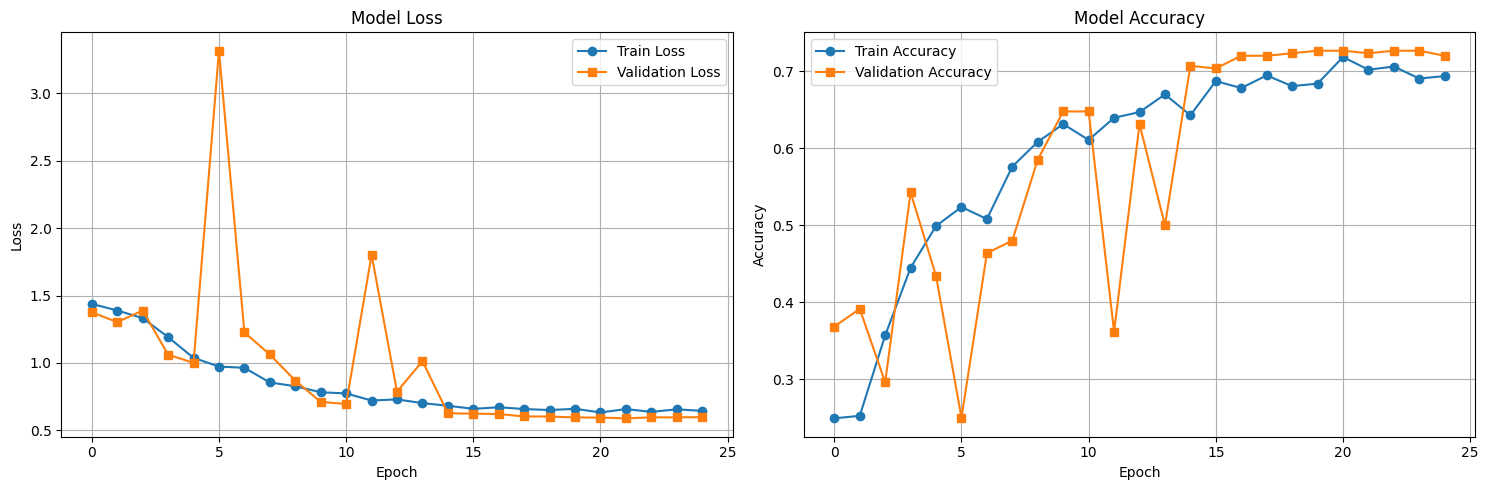

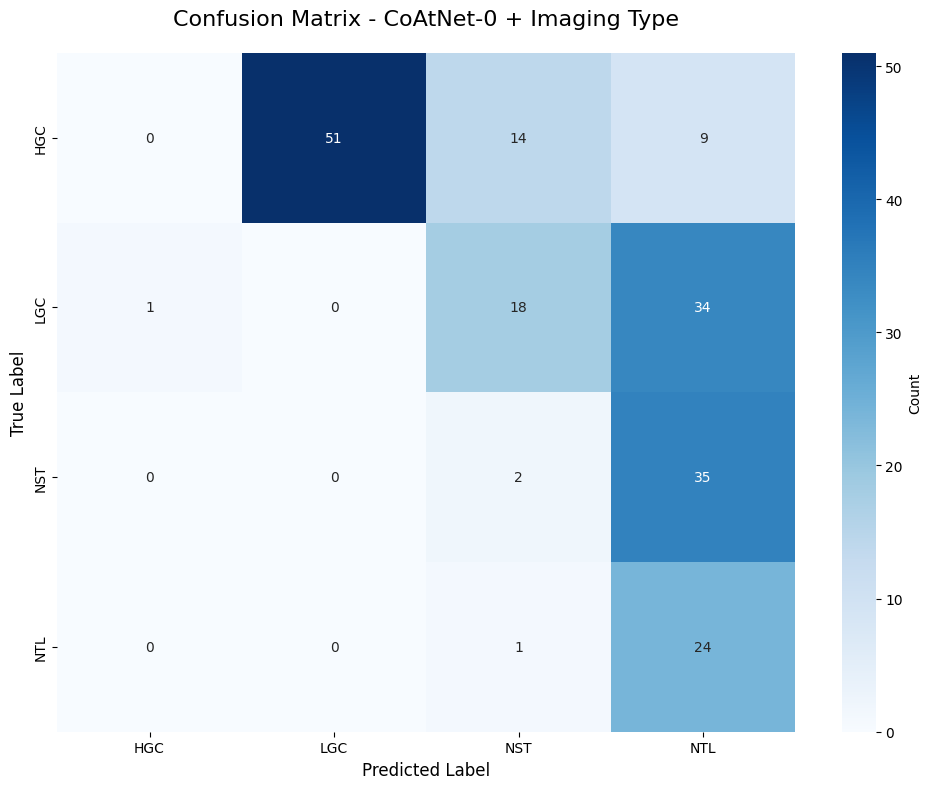

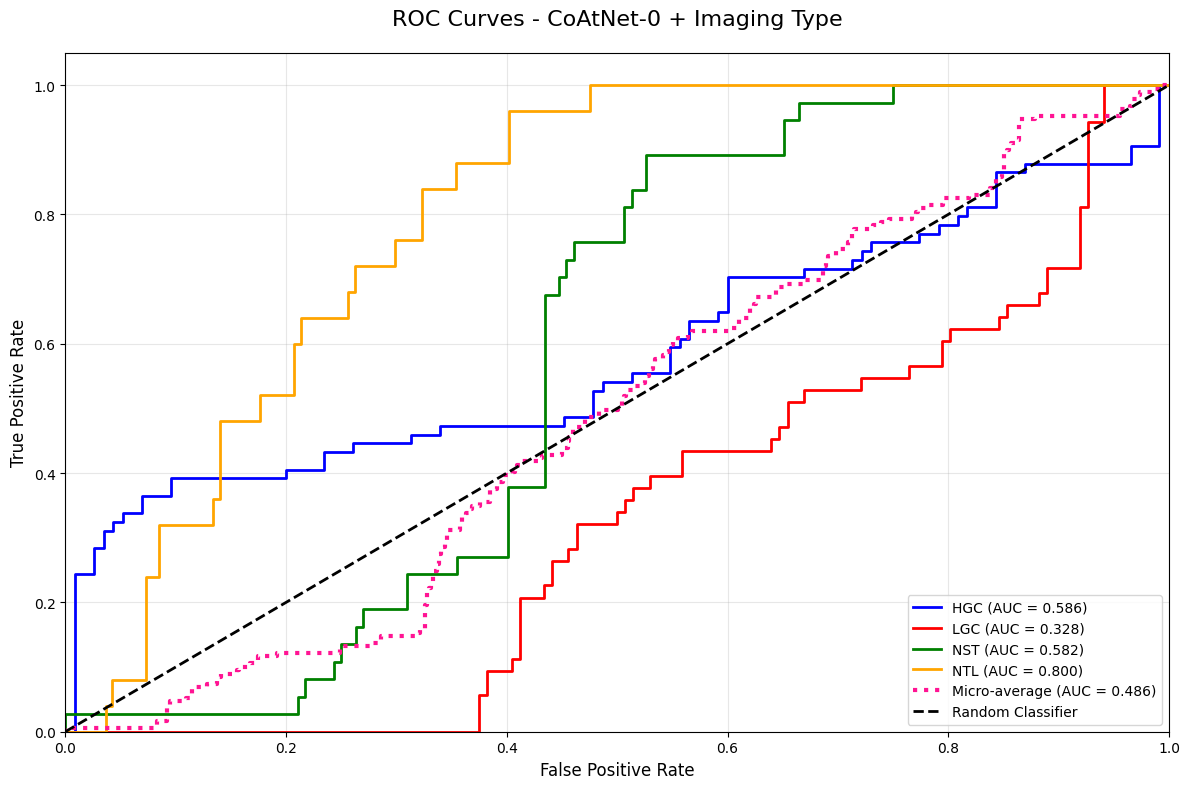


CoAtNet-0 with Imaging Type training and evaluation complete!


In [16]:
print("=" * 80)
print("Training CoAtNet-0 with Imaging Type")
print("=" * 80)

# Get number of imaging types
num_imaging_types = len(imaging_type_encoder.classes_)
print(f"Number of imaging types: {num_imaging_types}")
print(f"Imaging types: {imaging_type_encoder.classes_}")

# Create model
coatnet_0 = create_coatnet_model(
    model_type='0',
    num_classes=4,
    num_imaging_types=num_imaging_types,
    pretrained=True,
    embedding_dim=16
)

# Create trainer
trainer_coatnet_0 = ModelTrainer(coatnet_0, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_coatnet_0 = trainer_coatnet_0.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="CoAtNet-0_with_ImagingType")

# Plot training history
trainer_coatnet_0.plot_training_history(save_path='coatnet_0_with_imaging_training_history.png')

# Evaluate model
results_coatnet_0 = trainer_coatnet_0.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_coatnet_0['confusion_matrix'], class_names, 'CoAtNet-0 + Imaging Type',
                      save_path='coatnet_0_with_imaging_confusion_matrix.png')

# Plot ROC curves
roc_auc_coatnet_0 = plot_roc_curves(results_coatnet_0['labels'], results_coatnet_0['probabilities'], class_names, 'CoAtNet-0 + Imaging Type',
                                     save_path='coatnet_0_with_imaging_roc_curves.png')

# Store results
results_coatnet_0['model_name'] = 'CoAtNet-0'
results_coatnet_0['roc_auc'] = roc_auc_coatnet_0
all_results.append(results_coatnet_0)

print("\nCoAtNet-0 with Imaging Type training and evaluation complete!")

## Train CoAtNet-1

Training CoAtNet-1 with Imaging Type


model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=1.4003, Acc=0.3018]


Train Loss: 1.4003 Acc: 0.3018 Macro-F1: 0.2776


Val : 100%|██████████| 10/10 [00:02<00:00,  4.70it/s, Loss=1.5474, Acc=0.1842]


Val Loss: 1.5474 Acc: 0.1842 Macro-F1: 0.1807
✓ New best model saved with validation macro-F1: 0.1807

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=1.1340, Acc=0.4794]


Train Loss: 1.1340 Acc: 0.4794 Macro-F1: 0.4276


Val : 100%|██████████| 10/10 [00:02<00:00,  4.83it/s, Loss=1.0538, Acc=0.5362]


Val Loss: 1.0538 Acc: 0.5362 Macro-F1: 0.3708
✓ New best model saved with validation macro-F1: 0.3708

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=1.0282, Acc=0.5411]


Train Loss: 1.0282 Acc: 0.5411 Macro-F1: 0.4729


Val : 100%|██████████| 10/10 [00:02<00:00,  4.82it/s, Loss=0.7991, Acc=0.5789]


Val Loss: 0.7991 Acc: 0.5789 Macro-F1: 0.5350
✓ New best model saved with validation macro-F1: 0.5350

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=1.0682, Acc=0.5247]


Train Loss: 1.0682 Acc: 0.5247 Macro-F1: 0.4647


Val : 100%|██████████| 10/10 [00:02<00:00,  4.80it/s, Loss=0.9098, Acc=0.5296]


Val Loss: 0.9098 Acc: 0.5296 Macro-F1: 0.4037

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=0.9702, Acc=0.5551]


Train Loss: 0.9702 Acc: 0.5551 Macro-F1: 0.4905


Val : 100%|██████████| 10/10 [00:02<00:00,  4.75it/s, Loss=0.8709, Acc=0.5428]


Val Loss: 0.8709 Acc: 0.5428 Macro-F1: 0.3888

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=0.9742, Acc=0.5526]


Train Loss: 0.9742 Acc: 0.5526 Macro-F1: 0.4901


Val : 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, Loss=2.5501, Acc=0.3322]


Val Loss: 2.5501 Acc: 0.3322 Macro-F1: 0.2223

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.72it/s, Loss=0.9026, Acc=0.5765]


Train Loss: 0.9026 Acc: 0.5765 Macro-F1: 0.5351


Val : 100%|██████████| 10/10 [00:02<00:00,  4.84it/s, Loss=1.3758, Acc=0.4145]


Val Loss: 1.3758 Acc: 0.4145 Macro-F1: 0.3568

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.72it/s, Loss=0.8846, Acc=0.5658]


Train Loss: 0.8846 Acc: 0.5658 Macro-F1: 0.5319


Val : 100%|██████████| 10/10 [00:02<00:00,  4.83it/s, Loss=2.0632, Acc=0.3322]


Val Loss: 2.0632 Acc: 0.3322 Macro-F1: 0.1881
Early stopping triggered after 8 epochs
Training complete in 3m 15s
Best validation macro-F1: 0.5350
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


Test Accuracy: 44.97%
Test Loss: 1.9592

Classification Report:
              precision    recall  f1-score   support

         HGC       0.60      0.50      0.54        74
         LGC       0.45      0.64      0.53        53
         NST       0.23      0.19      0.21        37
         NTL       0.33      0.28      0.30        25

    accuracy                           0.45       189
   macro avg       0.40      0.40      0.40       189
weighted avg       0.45      0.45      0.44       189


Confusion Matrix:
[[37 14 22  1]
 [15 34  1  3]
 [ 4 16  7 10]
 [ 6 12  0  7]]

ROC-AUC Scores:
Macro-average AUC: 0.7090
Micro-average AUC: 0.6445
HGC AUC: 0.6105
LGC AUC: 0.8055
NST AUC: 0.7463
NTL AUC: 0.6739


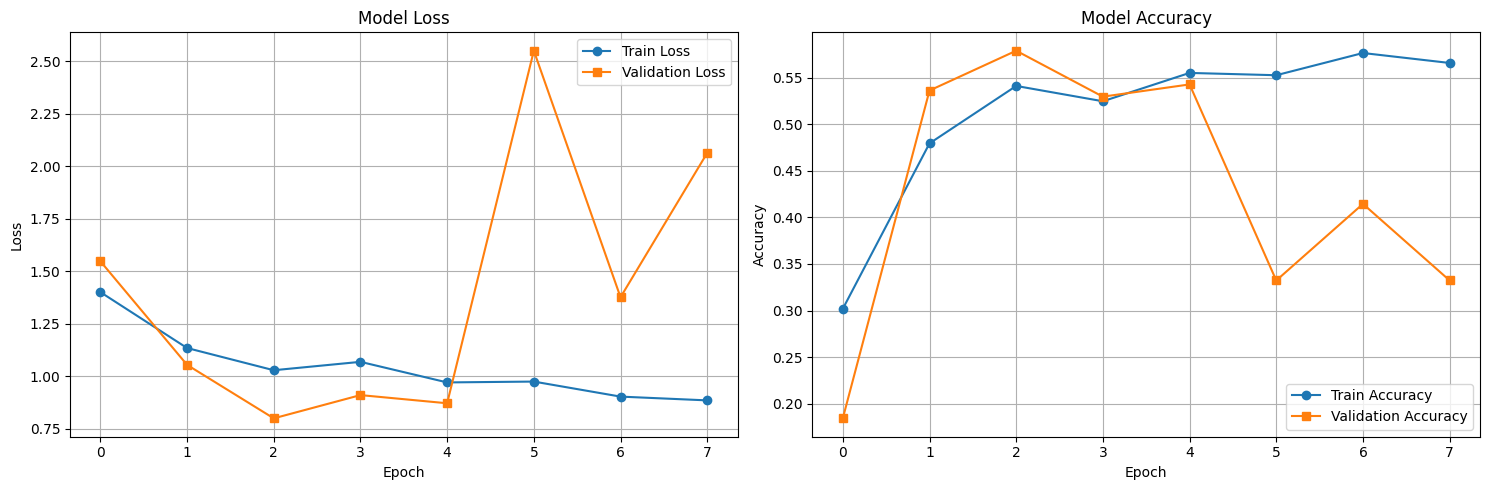

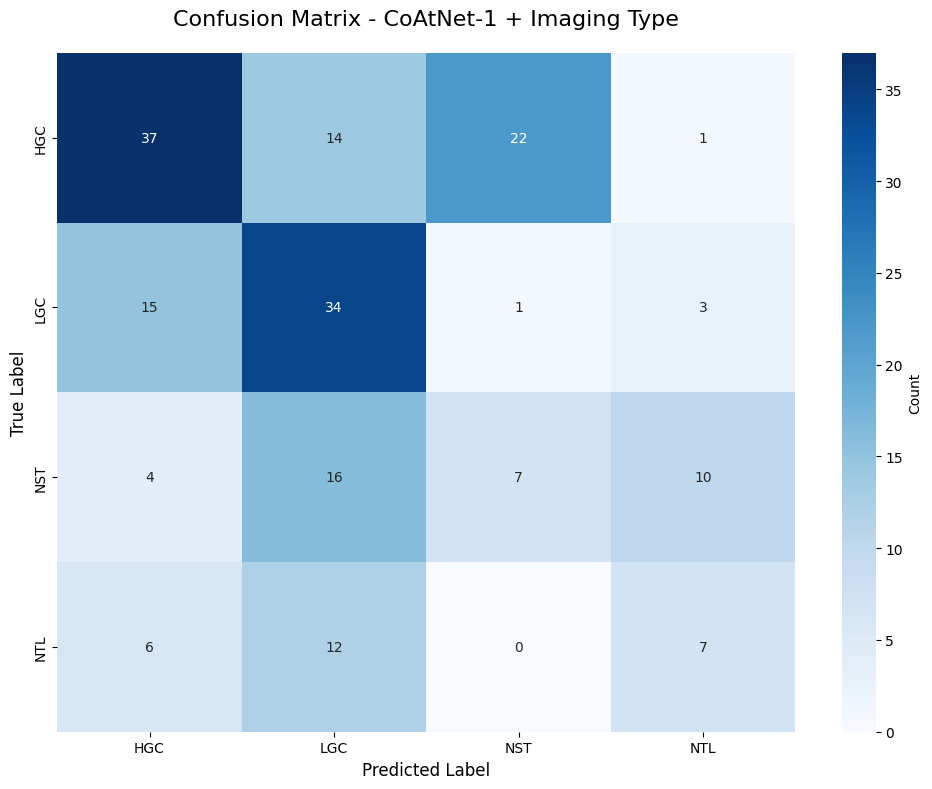

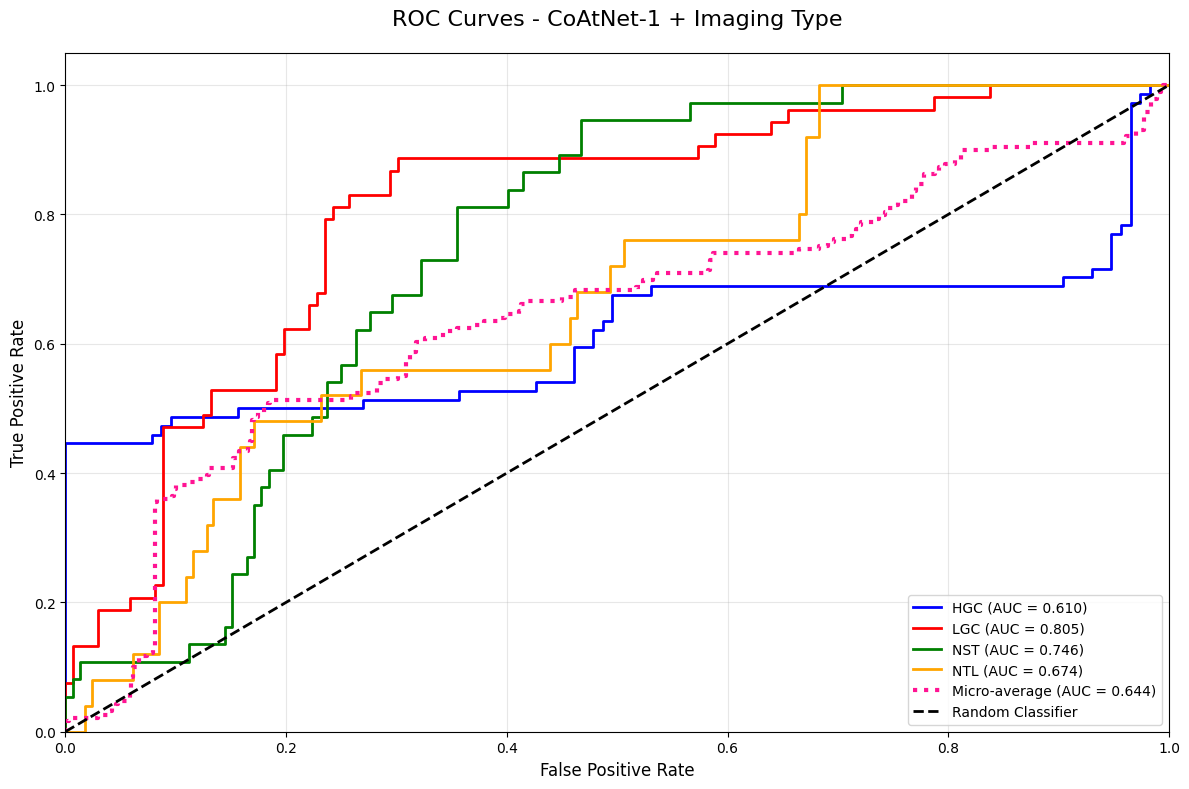


CoAtNet-1 with Imaging Type training and evaluation complete!


In [17]:
print("=" * 80)
print("Training CoAtNet-1 with Imaging Type")
print("=" * 80)

# Create model
coatnet_1 = create_coatnet_model(
    model_type='1',
    num_classes=4,
    num_imaging_types=num_imaging_types,
    pretrained=True,
    embedding_dim=16
)

# Create trainer
trainer_coatnet_1 = ModelTrainer(coatnet_1, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_coatnet_1 = trainer_coatnet_1.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="CoAtNet-1_with_ImagingType")

# Plot training history
trainer_coatnet_1.plot_training_history(save_path='coatnet_1_with_imaging_training_history.png')

# Evaluate model
results_coatnet_1 = trainer_coatnet_1.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_coatnet_1['confusion_matrix'], class_names, 'CoAtNet-1 + Imaging Type',
                      save_path='coatnet_1_with_imaging_confusion_matrix.png')

# Plot ROC curves
roc_auc_coatnet_1 = plot_roc_curves(results_coatnet_1['labels'], results_coatnet_1['probabilities'], class_names, 'CoAtNet-1 + Imaging Type',
                                     save_path='coatnet_1_with_imaging_roc_curves.png')

# Store results
results_coatnet_1['model_name'] = 'CoAtNet-1'
results_coatnet_1['roc_auc'] = roc_auc_coatnet_1
all_results.append(results_coatnet_1)

print("\nCoAtNet-1 with Imaging Type training and evaluation complete!")

# Save All Metrics to CSV

In [18]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'CoAtNet_with_ImagingType_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: CoAtNet_with_ImagingType_metrics.csv

Metrics Summary:
       Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  CoAtNet-0         13.756614      2.716496             0.073109          0.253514      0.108377                0.042310             0.137566         0.060870       0.000000         0.0  0.000000         74.0       0.000000    0.000000  0.000000         53.0       0.057143    0.054054  0.055556         37.0       0.235294        0.96  0.377953         25.0   0.573866   0.485905  0.585664  0.327830  0.581970  0.800000      0